In [2]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline
plt.rcParams['font.size'] = 22
plt.rcParams.update({'figure.figsize': (20,10)})
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
# mpl.rcParams.keys()

In [3]:
!cd data && ls

2014-05 - Citi Bike trip data.csv  taxi_tree_test_X.csv
bike_oneweekfrom20140505.csv	   taxi_tree_test_Xy.csv
data_jan13.csv			   taxi_tree_test_Xy_sample.csv
README.txt			   taxi_tree_test_y.csv
taxi_oneweekfrom20130107.csv	   yellow_tripdata_2013-05.csv
taxi_oneweekfrom20130506.csv	   yellow_tripdata_2014-05.csv
taxi_oneweekfrom20140505.csv


Use the bash =)

In [4]:
data = pd.read_csv('data/taxi_oneweekfrom20130506.csv', index_col=0, parse_dates=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 18 columns):
vendor_id             object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code             int64
store_and_fwd_flag    object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtypes: float64(11), int64(2), object(5)
memory usage: 512.4+ MB


So parsing doe not work, do it manually:

In [6]:
data['pickup_datetime'] =pd.to_datetime(data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] =pd.to_datetime(data['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [7]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
rate_code,3534632.0,1.032870,0.345708,0.000000,1.000000,1.000000,1.000000,210.000000
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
surcharge,3534632.0,0.320163,0.362772,0.000000,0.000000,0.000000,0.500000,9.500000
mta_tax,3534632.0,0.498208,0.029876,0.000000,0.500000,0.500000,0.500000,0.500000


In [8]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,1,NaN,-73.981362,40.738092,CRD,10.5,0.5,0.5,2.20,0.0,13.70
1,VTS,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,1,NaN,-74.005082,40.743372,CSH,7.5,0.5,0.5,0.00,0.0,8.50
2,VTS,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,1,NaN,-73.986102,40.740732,CSH,5.5,0.5,0.5,0.00,0.0,6.50
3,VTS,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,1,NaN,-73.963470,40.765912,CSH,9.5,0.5,0.5,0.00,0.0,10.50
4,VTS,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,1,NaN,-73.974808,40.624810,CRD,51.5,0.5,0.5,6.75,0.0,59.25


In [9]:
payments = data.payment_type.value_counts()

In [10]:
payments/len(data)

CRD    0.537525
CSH    0.459272
NOC    0.002171
DIS    0.000694
UNK    0.000339
Name: payment_type, dtype: float64

In [11]:
data.tolls_amount.value_counts()/len(data)

0.00     9.535745e-01
5.33     4.322657e-02
10.25    1.000670e-03
2.44     4.175824e-04
8.25     3.850472e-04
10.66    2.648083e-04
4.80     9.760563e-05
7.50     8.345989e-05
15.58    7.016289e-05
15.99    6.591917e-05
15.00    3.904225e-05
15.25    3.762768e-05
13.25    3.564728e-05
14.25    3.281813e-05
12.25    3.196938e-05
13.00    2.998898e-05
2.00     2.319902e-05
13.58    2.291611e-05
12.00    2.291611e-05
14.00    1.867238e-05
5.00     1.782364e-05
16.25    1.612615e-05
12.75    1.527740e-05
5.30     1.471157e-05
16.00    1.357991e-05
14.75    1.273117e-05
17.00    1.159951e-05
14.55    1.103368e-05
12.40    1.046785e-05
16.50    1.018494e-05
             ...     
8.24     2.829149e-07
5.74     2.829149e-07
17.99    2.829149e-07
12.58    2.829149e-07
16.16    2.829149e-07
5.31     2.829149e-07
0.06     2.829149e-07
13.06    2.829149e-07
12.97    2.829149e-07
6.80     2.829149e-07
4.30     2.829149e-07
4.55     2.829149e-07
12.22    2.829149e-07
17.80    2.829149e-07
13.80    2

So 95% of the drives do not deal with tolls. We will drop the column then.

# <font color = 'blue'>  So thats the statistic about payments. Remember, there are to tips recorded for cash payment. </font color>

We are not interested in the following features (they do not add any further information):

In [12]:
data = data.drop(['vendor_id', 'rate_code', 'store_and_fwd_flag','payment_type','mta_tax', 'tolls_amount',
               'surcharge'], axis=1)

In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
tip_amount,3534632.0,1.366541,2.157769,0.000000,0.000000,1.000000,2.000000,155.500000
total_amount,3534632.0,14.936348,12.109785,2.500000,8.000000,11.300000,16.750000,500.000000


# First, we want to generate the trip_time because this is our target.

In [14]:
data['trip_time']=data.dropoff_datetime-data.pickup_datetime
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time
0,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00
1,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,0.00,8.50,00:06:00
2,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,0.00,6.50,00:04:00
3,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,0.00,10.50,00:08:00
4,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 12 columns):
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
passenger_count      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
fare_amount          float64
tip_amount           float64
total_amount         float64
trip_time            timedelta64[ns]
dtypes: datetime64[ns](2), float64(8), int64(1), timedelta64[ns](1)
memory usage: 350.6 MB


# Check for missing and false data:

In [16]:
data.isnull().sum()

pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
fare_amount           0
tip_amount            0
total_amount          0
trip_time             0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [17]:
(data==0).sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63932
dropoff_latitude       63565
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

So we have many zeros in the data. How much percent?

In [18]:
(data==0).sum()/len(data)

pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000009
trip_distance        0.011202
pickup_longitude     0.017487
pickup_latitude      0.017372
dropoff_longitude    0.018087
dropoff_latitude     0.017983
fare_amount          0.000000
tip_amount           0.478255
total_amount         0.000000
trip_time            0.003014
dtype: float64

# <font color = 'blue' > Most of the zeros are missing data. So flag them as NaN (means also NA) to be consistent! </font color>

In [19]:
data = data.replace(np.float64(0), np.nan);

In [20]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63946
dropoff_latitude       63579
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

Quick pverview about the trip_times

(array([  1.61220300e+06,   1.29468100e+06,   4.12814000e+05,
          1.25617000e+05,   4.35840000e+04,   1.94290000e+04,
          8.85200000e+03,   3.73500000e+03,   1.60400000e+03,
          7.39000000e+02,   3.57000000e+02,   1.34000000e+02,
          8.20000000e+01,   5.00000000e+01,   3.10000000e+01,
          2.10000000e+01,   1.50000000e+01,   7.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.]),
 <a list of 30 Patch objects>)

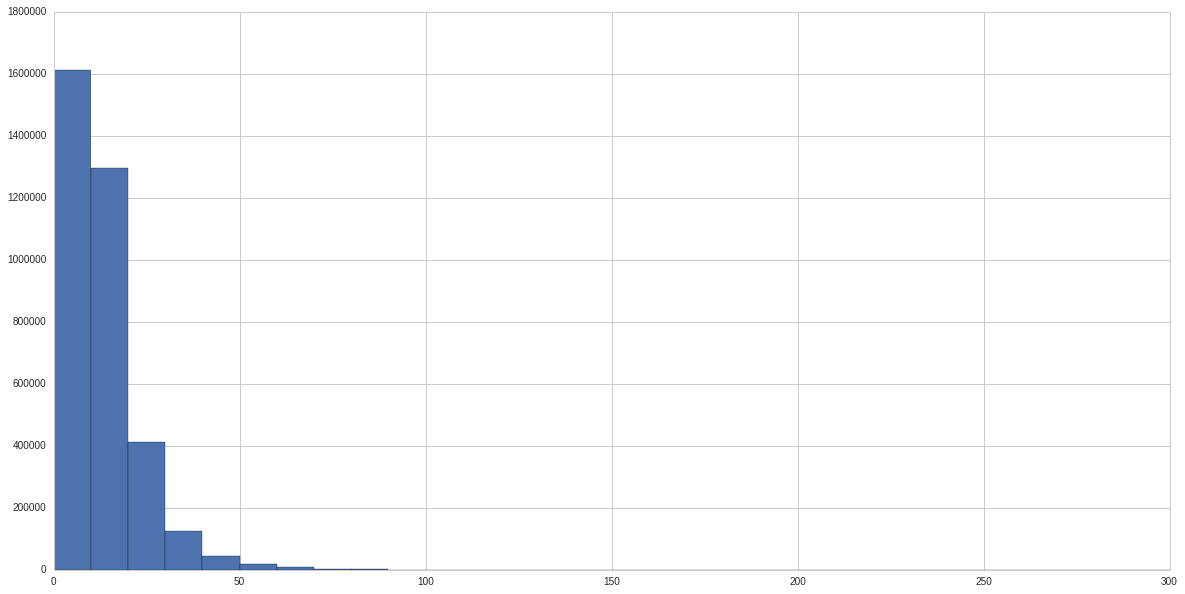

In [21]:
plt.hist(data['trip_time'] / np.timedelta64(1, 'm'), bins=30, range=[0, 300])
#plt.yscale('log')

In [22]:
len(data.trip_time.value_counts().values)

5840

Identify the the cases without geo data and remove them from our data to be processed.

In [23]:
anomaly = data.loc[(data['dropoff_longitude'].isnull()) | (data['dropoff_latitude'].isnull()) | 
                       (data['pickup_longitude'].isnull()) | (data['pickup_latitude'].isnull())]
data = data.drop(anomaly.index)

In [24]:
anomaly['flag'] = 'geo_NA'

In [25]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           12
trip_distance          32873
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1656902
total_amount               0
trip_time               3864
dtype: int64

So how many percent of data are left to be processed?

In [26]:
len(data)/(len(data)+len(anomaly))

0.981279805082962

In [27]:
anomaly.tail()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,flag
3534421,2013-05-12 23:58:56,2013-05-13 00:05:43,1.0,2.0,NaN,NaN,NaN,NaN,8.0,1.8,10.8,00:06:47,geo_NA
3534518,2013-05-12 23:59:02,2013-05-13 00:16:03,3.0,6.1,NaN,NaN,NaN,NaN,15.0,NaN,16.0,00:17:01,geo_NA
3534615,2013-05-12 23:59:52,2013-05-13 00:23:15,1.0,5.4,NaN,NaN,NaN,NaN,20.5,NaN,21.5,00:23:23,geo_NA
3534618,2013-05-12 23:59:54,2013-05-13 00:07:45,1.0,1.8,NaN,NaN,NaN,NaN,8.0,NaN,9.0,00:07:51,geo_NA
3534623,2013-05-12 23:59:56,2013-05-13 00:14:28,1.0,7.6,NaN,NaN,NaN,NaN,23.0,NaN,24.0,00:14:32,geo_NA


# <font color = 'blue'> So we only dropped 2% of the data because of missing geo tags. Someone could search the 'anomaly'-data for patterns, e.g. for fraud detection. We are also going to drop all the unrecognized trip_distances because we cannot (exactly) generate them (an approximation would be possible). </font color>

In [28]:
#taxidata.loc[(taxidata['trip_distance'].isnull())]
#print(len(anomaly))
anomaly = anomaly.append(data.loc[(data['trip_distance'].isnull())])
anomaly.loc[data.loc[(data['trip_distance'].isnull())].index,'flag'] = 'trip_dist_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534334,2013-05-13 00:03:12,40.749736,-73.978713,5.5,trip_dist_NA,1.0,2013-05-12 23:58:16,40.754459,-73.964803,NaN,6.5,NaN,00:04:56
3534517,2013-05-13 00:13:53,40.690212,-73.978735,14.0,trip_dist_NA,1.0,2013-05-12 23:59:01,40.733297,-73.987381,NaN,15.0,NaN,00:14:52
3534607,2013-05-13 00:05:02,40.744680,-73.999020,6.0,trip_dist_NA,1.0,2013-05-12 23:59:50,40.733435,-74.002994,NaN,7.0,NaN,00:05:12
3534612,2013-05-13 00:09:30,40.706187,-74.013075,9.5,trip_dist_NA,1.0,2013-05-12 23:59:52,40.729327,-73.992207,NaN,10.5,NaN,00:09:38
3534626,2013-05-13 00:00:28,40.757354,-73.967262,58.0,trip_dist_NA,1.0,2013-05-12 23:59:58,40.757354,-73.967262,11.6,69.6,NaN,00:00:30


In [29]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

In [30]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1638285
total_amount               0
trip_time               2922
dtype: int64

In [31]:
1-len(data)/(len(data)+len(anomaly))

0.028020455877726502

# Drop all the columns with trip_time.isnull()

In [32]:
anomaly = anomaly.append(data.loc[(data['trip_time'].isnull())])
anomaly.loc[data.loc[(data['trip_time'].isnull())].index,'flag'] = 'trip_time_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [33]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

# This is quite unreasonable. We have dropoff_datetime = pickup_datetime and the geo-coords of pickup and dropoff do not match! trip_time equals NaT here.

In [34]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3.43266e+06,1.71448,1.38599,1,1,1,2,6
trip_distance,3.43267e+06,2.91113,3.34836,0.01,1.09,1.8,3.21,100
pickup_longitude,3.43267e+06,-73.9154,2.68755,-736.5,-73.9925,-73.9821,-73.968,40.8679
pickup_latitude,3.43267e+06,40.6919,2.91217,-74.0378,40.7365,40.7534,40.7679,2047.45
dropoff_longitude,3.43267e+06,-73.913,2.98107,-740.173,-73.9918,-73.9806,-73.9651,2387
dropoff_latitude,3.43267e+06,40.6899,3.43265,-3084.28,40.7353,40.7538,40.7686,473.982
fare_amount,3.43267e+06,12.4022,9.71666,2.5,6.5,9.5,14.5,382.75
tip_amount,1.79648e+06,2.59194,2.29176,0.01,1.3,2,3,155.5
total_amount,3.43267e+06,14.834,11.7278,2.5,8,11.3,16.7,382.76
trip_time,3432668,0 days 00:13:02.243506,0 days 00:27:26.535018,0 days 00:00:01,0 days 00:06:24,0 days 00:10:34,0 days 00:16:50,11 days 00:45:28


(array([  4.14860000e+04,   2.47244000e+05,   4.11413000e+05,
          4.47479000e+05,   4.18108000e+05,   3.64416000e+05,
          3.02291000e+05,   2.45960000e+05,   1.96811000e+05,
          1.57134000e+05,   1.23172000e+05,   9.75690000e+04,
          7.55190000e+04,   5.99140000e+04,   4.69780000e+04,
          3.66970000e+04,   2.90370000e+04,   2.32160000e+04,
          1.81990000e+04,   1.47690000e+04,   1.18490000e+04,
          9.75400000e+03,   7.90100000e+03,   6.83100000e+03,
          5.64600000e+03,   4.78400000e+03,   4.11200000e+03,
          3.75100000e+03,   3.13700000e+03,   2.76200000e+03,
          2.28500000e+03,   1.89500000e+03,   1.59500000e+03,
          1.43000000e+03,   1.15200000e+03,   1.03000000e+03,
          8.11000000e+02,   7.01000000e+02,   5.63000000e+02,
          4.33000000e+02,   3.88000000e+02,   3.50000000e+02,
          2.88000000e+02,   2.23000000e+02,   2.36000000e+02,
          1.84000000e+02,   1.59000000e+02,   1.33000000e+02,
        

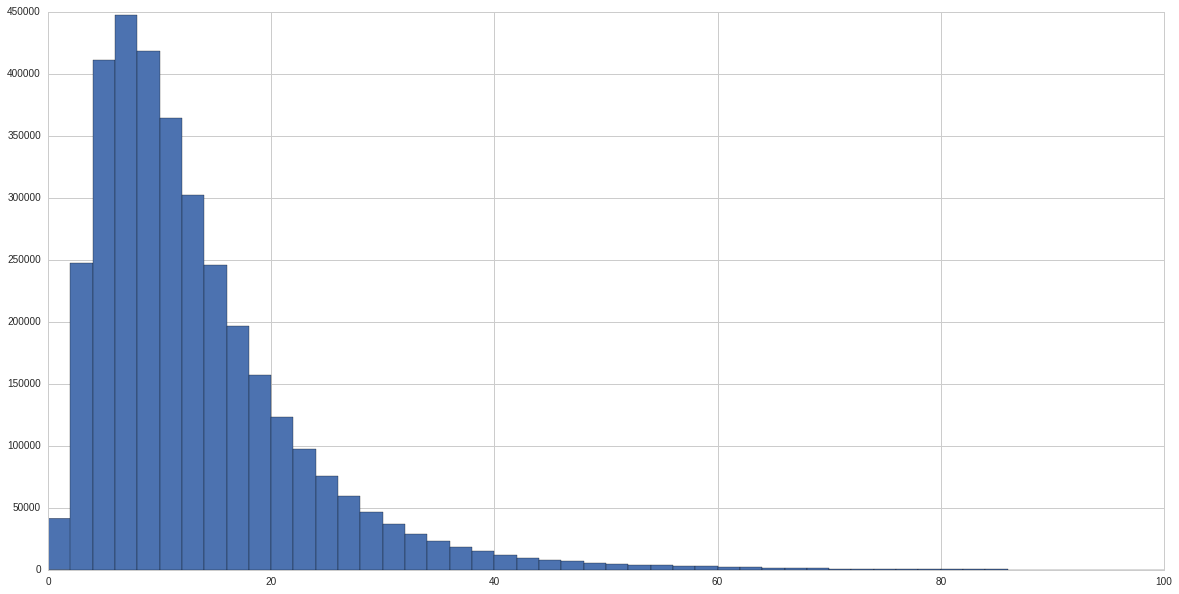

In [35]:
plt.hist(data.trip_time.values / np.timedelta64(1, 'm'), bins=50, range=[0,100])

In [36]:
print(data.trip_time.describe())
np.percentile(data.trip_time, [1,5,10,15,25,50,75,85,95,99]) / np.timedelta64(1,'m')

count                   3432668
mean     0 days 00:13:02.243506
std      0 days 00:27:26.535018
min             0 days 00:00:01
25%             0 days 00:06:24
50%             0 days 00:10:34
75%             0 days 00:16:50
max            11 days 00:45:28
Name: trip_time, dtype: object


array([  1.7945    ,   3.        ,   4.        ,   5.        ,
         6.4       ,  10.56666667,  16.83333333,  21.        ,
        31.        ,  49.08883333])

# We sometimes have some unreasonably small trip_times.

In [37]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [38]:
1-len(data)/(len(data)+len(anomaly))

0.028847133166903904

# <font color = 'blue'> So all in all, we dropped less than 3% of the data. </font color>

In [39]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1636185
total_amount               0
trip_time                  0
dtype: int64

We can deal with that. External investigation of the anomaly is recommended.

# Start validating the non-anomaly data: Valid trip_time, valid distance?

# <font color = 'red'> An ECDF with logarithmic scale might be suitable right here for identifying unreasonably small trip_times. Have a look at the average amount per time! </font color>

Correct the avg amount for the initial charge. 

In [40]:
data['avg_amount_per_minute'] = (data.fare_amount-2.5) / (data.trip_time / np.timedelta64(1,'m'))

In [41]:
data.avg_amount_per_minute.describe()

count    3.432668e+06
mean     7.865239e-01
std      6.410160e+00
min      0.000000e+00
25%      5.769231e-01
50%      6.629834e-01
75%      7.857143e-01
max      6.450000e+03
Name: avg_amount_per_minute, dtype: float64

Min:0.0
Max:6450.0


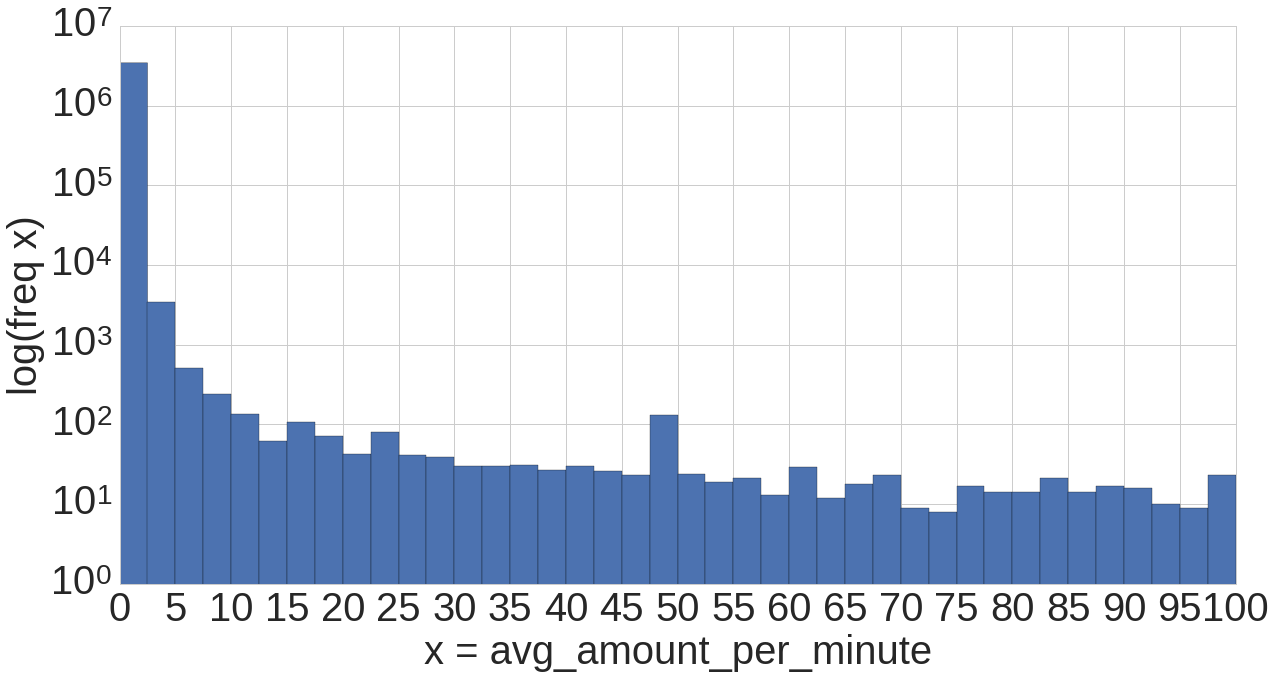

In [42]:
h = data.avg_amount_per_minute
plt.figure(figsize=(20,10))
plt.hist(h, normed=False, stacked=True, bins=40, range=[0 , 100], )
    #, histtype='stepfilled')
plt.yscale('log')
plt.ylabel('log(freq x)', fontsize=40)
plt.xlabel('x = avg_amount_per_minute', fontsize=40)
print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [43]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.50,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.50,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.50,00:08:00,0.875000
4,2013-05-06,2013-05-06 00:29:00,1.0,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00,1.689655


In [44]:
data.avg_amount_per_minute.quantile([.0001,.01, .5, .75, .95, .975, .99, .995])

0.0001    0.000000
0.0100    0.437318
0.5000    0.662983
0.7500    0.785714
0.9500    1.151163
0.9750    1.344677
0.9900    1.605263
0.9950    1.847222
Name: avg_amount_per_minute, dtype: float64

# Compare to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml . We have a strict lower bound with .5 \$ per minute (taxi waiting in congestion). 1 \$ per minute match roughly 2 miles / minute (no static fares included!). So the taxi would drive 120 miles/minute.  

In [46]:
lb = 0.5
ub = 1
anomaly = anomaly.append(data.loc[(data['avg_amount_per_minute'] > ub) | (data['avg_amount_per_minute'] < lb)])
#anomaly.loc[
anomaly.loc[data.loc[(data['avg_amount_per_minute'] > ub)].index,'flag'] = 'too fast'
anomaly.loc[data.loc[(data['avg_amount_per_minute'] < lb)].index,'flag'] = 'too slow'
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(data)/(len(data)+len(anomaly)))

0.14044941595051474


In [47]:
data.avg_amount_per_minute.describe()

count    3.038195e+06
mean     6.735544e-01
std      1.237572e-01
min      5.000000e-01
25%      5.769231e-01
50%      6.500000e-01
75%      7.500000e-01
max      1.000000e+00
Name: avg_amount_per_minute, dtype: float64

In [48]:
anomaly.tail()

,avg_amount_per_minute,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534609,1.678322,2013-05-13 00:33:13,40.671968,-73.973026,58.5,too fast,1.0,2013-05-12 23:59:51,40.646834,-73.789637,11.9,71.4,21.9,00:33:22
3534611,1.061321,2013-05-13 00:06:56,40.772749,-73.955794,10.0,too fast,1.0,2013-05-12 23:59:52,40.743763,-73.985840,2.2,13.2,2.9,00:07:04
3534622,1.019417,2013-05-13 00:27:24,40.691357,-73.867019,30.5,too fast,1.0,2013-05-12 23:59:56,40.644692,-73.781850,NaN,31.5,8.9,00:27:28
3534627,1.374570,2013-05-13 00:14:31,40.825470,-73.953479,22.5,too fast,2.0,2013-05-12 23:59:58,40.744021,-73.999512,4.7,28.2,7.3,00:14:33
3534629,1.860283,2013-05-13 00:21:13,40.644504,-73.963537,42.0,too fast,1.0,2013-05-12 23:59:59,40.770077,-73.863887,8.6,51.6,15.6,00:21:14


# <font color = 'red' > Drop even more columns (e.g. tip)? </font color>

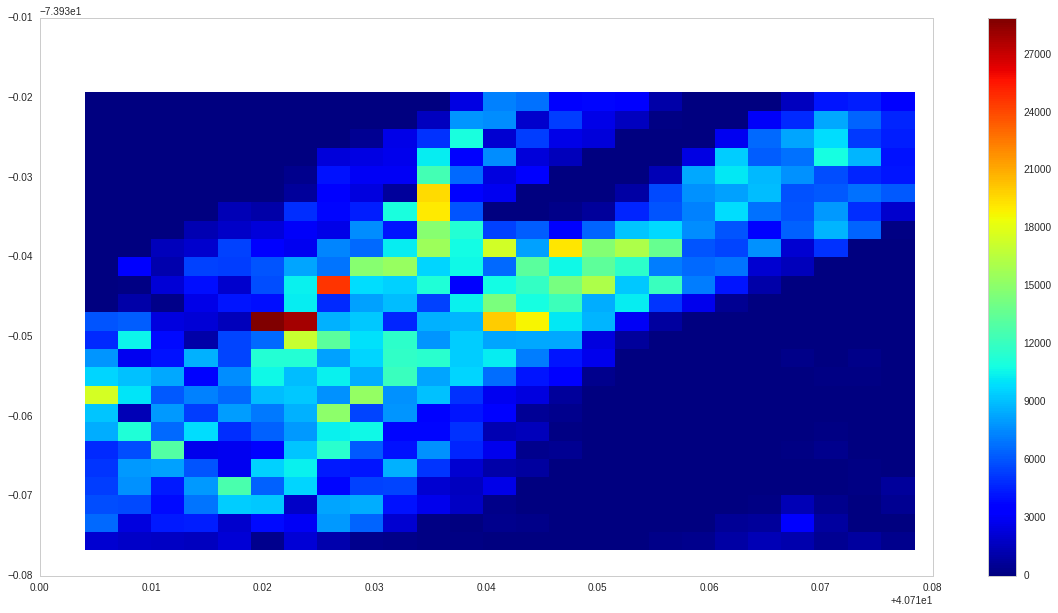

In [49]:
x = data.pickup_latitude
y = data.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=25, range=[ [x.quantile(.05), x.quantile(.95)], 
        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [50]:
type(H)

numpy.ndarray

In [51]:
print(H.shape)
print(H.size)
print(H.max())

(25, 25)
625
28883.0


In [52]:
print(xedges.shape)
xedges[0]

(26,)


40.714093699999999

In [53]:
print(xedges)
print(yedges)

[ 40.7140937   40.71706515  40.7200366   40.72300806  40.72597951
  40.72895096  40.73192241  40.73489386  40.73786532  40.74083677
  40.74380822  40.74677967  40.74975112  40.75272258  40.75569403
  40.75866548  40.76163693  40.76460838  40.76757984  40.77055129
  40.77352274  40.77649419  40.77946564  40.7824371   40.78540855  40.78838   ]
[-74.00675    -74.00445292 -74.00215584 -73.99985876 -73.99756168
 -73.9952646  -73.99296752 -73.99067044 -73.98837336 -73.98607628
 -73.9837792  -73.98148212 -73.97918504 -73.97688796 -73.97459088
 -73.9722938  -73.96999672 -73.96769964 -73.96540256 -73.96310548
 -73.9608084  -73.95851132 -73.95621424 -73.95391716 -73.95162008
 -73.949323  ]


In [54]:
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).kilometers)
#538.3904451566326

866.4554329011002


In [55]:
print('Current bin width:')
print(vincenty((xedges[0], yedges[0]), (xedges[1], yedges[1])).meters)

Current bin width:
382.8261547939702


In [56]:
distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters

In [57]:
print('Sizes of all bins in meters:')
distances

Sizes of all bins in meters:


array([ 382.82615479,  382.82192645,  382.81769799,  382.81346942,
        382.80924073,  382.80501193,  382.80078301,  382.79655398,
        382.79232483,  382.78809556,  382.78386618,  382.77963669,
        382.77540708,  382.77117735,  382.76694751,  382.76271755,
        382.75848748,  382.7542573 ,  382.750027  ,  382.74579658,
        382.74156605,  382.73733541,  382.73310465,  382.72887377,
        382.72464278])

In [58]:
print(str(max(data.pickup_latitude)) +','+ str(max(data.pickup_longitude)))
print(str(max(data.dropoff_latitude)) +','+ str(max(data.dropoff_longitude)))

2047.45495,40.867882
473.981648,2386.995232


# What is going on here? Surprising values in lon/lat?

# Only look at trips in a given bounding box


In [59]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
data_in_box = data.loc[(data['dropoff_latitude'] > jfk_geodata[0]) & 
                       (data['dropoff_longitude'] < jfk_geodata[1]) &
                       (data['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (data['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (data['pickup_latitude'] > jfk_geodata[0]) & 
                       (data['pickup_longitude'] < jfk_geodata[1]) &
                       (data['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (data['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

<font color = 'red'> Be careful! They use negative (lat, long), not East/West! </font color>

In [60]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


In [61]:
jfk_geodata < ridgefield_geodata
len(data_in_box)/len(data)

0.9946053495578789

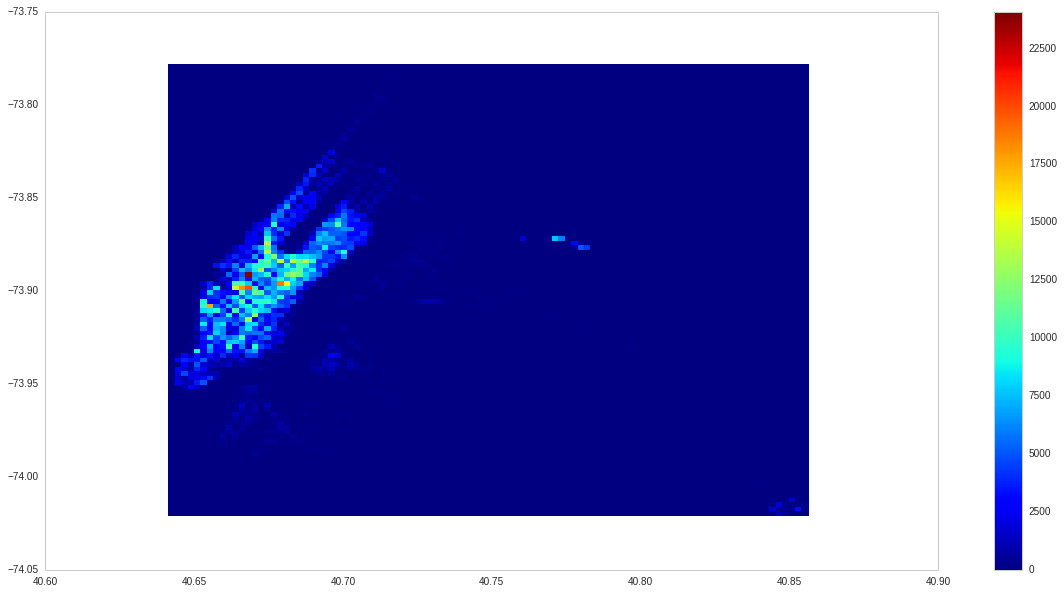

In [62]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [63]:
print(H.shape)
print(H.size)
print(H.max())
print(xedges.shape)
print(xedges)
print(yedges)

distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters
    
print('Sizes of all bins in meters:')
distances

(100, 100)
10000
24068.0
(101,)
[ 40.641548    40.64369611  40.64584422  40.64799233  40.65014044
  40.65228855  40.65443666  40.65658477  40.65873288  40.66088099
  40.6630291   40.66517721  40.66732532  40.66947343  40.67162154
  40.67376965  40.67591776  40.67806587  40.68021398  40.68236209
  40.6845102   40.68665831  40.68880642  40.69095453  40.69310264
  40.69525075  40.69739886  40.69954697  40.70169508  40.70384319
  40.7059913   40.70813941  40.71028752  40.71243563  40.71458374
  40.71673185  40.71887996  40.72102807  40.72317618  40.72532429
  40.7274724   40.72962051  40.73176862  40.73391673  40.73606484
  40.73821295  40.74036106  40.74250917  40.74465728  40.74680539
  40.7489535   40.75110161  40.75324972  40.75539783  40.75754594
  40.75969405  40.76184216  40.76399027  40.76613838  40.76828649
  40.7704346   40.77258271  40.77473082  40.77687893  40.77902704
  40.78117515  40.78332326  40.78547137  40.78761948  40.78976759
  40.7919157   40.79406381  40.79621192  40.

array([ 314.61402538,  314.609805  ,  314.6055845 ,  314.6013639 ,
        314.59714319,  314.59292237,  314.58870145,  314.58448042,
        314.58025928,  314.57603803,  314.57181668,  314.56759522,
        314.56337366,  314.55915198,  314.5549302 ,  314.55070832,
        314.54648632,  314.54226422,  314.53804202,  314.5338197 ,
        314.52959728,  314.52537475,  314.52115212,  314.51692937,
        314.51270653,  314.50848357,  314.50426051,  314.50003734,
        314.49581407,  314.49159069,  314.4873672 ,  314.4831436 ,
        314.4789199 ,  314.47469609,  314.47047218,  314.46624816,
        314.46202403,  314.4577998 ,  314.45357545,  314.44935101,
        314.44512645,  314.44090179,  314.43667703,  314.43245216,
        314.42822718,  314.42400209,  314.4197769 ,  314.4155516 ,
        314.4113262 ,  314.40710069,  314.40287507,  314.39864935,
        314.39442352,  314.39019758,  314.38597154,  314.38174539,
        314.37751914,  314.37329278,  314.36906631,  314.36483

In [64]:
(H==0).sum()/H.size

0.58089999999999997

# So we know that 60% of the bins have 0 pickups in it.

## Let's take a first look at the distribution if the target variable which we want to estimate:

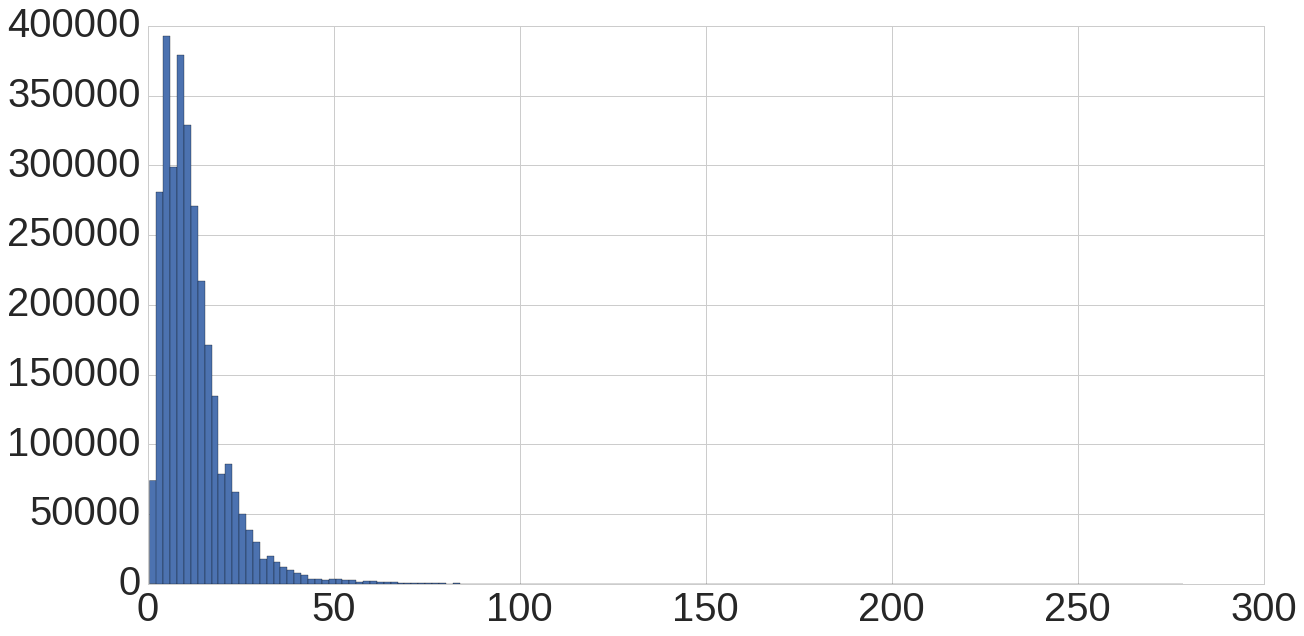

In [65]:
h = data_in_box.trip_time.values / np.timedelta64(1, 'm')
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=150)
    #, histtype='stepfilled')
#plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [66]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


In [67]:
#data_in_box['pickup_datetime'].dt.dayofweek
#tdata_in_box['pickup_datetime'].dt.hourb
#data_in_box['pickup_datetime'].dt.month # year, month, day, hour, minute, second, microsecond, and tzinfo.
#data_in_box['pickup_datetime'].dt.day

# Make a new dataframe with features and targets

In [68]:
time_regression_df = pd.DataFrame([data_in_box['pickup_datetime'].dt.day,
                          data_in_box['pickup_datetime'].dt.dayofweek,
                          data_in_box['pickup_datetime'].dt.hour,
                          data_in_box['pickup_latitude'],
                          data_in_box['pickup_longitude'],
                          data_in_box['dropoff_latitude'],
                          data_in_box['dropoff_longitude'],
                          np.ceil(data_in_box['trip_time']/np.timedelta64(1, 'm')),
                         ]).T

In [69]:
time_regression_df.columns = ['pickup_datetime_day', 'pickup_datetime_dayofweek', 'pickup_datetime_hour',
                                 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                                 'trip_time_in_mins']

Use minutes for prediction instead of seconds (ceil the time). Definitley more robust than seconds!

In [70]:
time_regression_df.tail()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
3534624,12.0,6.0,23.0,40.714082,-73.955942,40.664741,-73.982268,18.0
3534625,12.0,6.0,23.0,40.694740,-73.994390,40.683171,-74.001398,6.0
3534628,12.0,6.0,23.0,40.741475,-73.981322,40.751637,-73.975838,3.0
3534630,12.0,6.0,23.0,40.736240,-73.990593,40.744194,-73.985401,5.0
3534631,12.0,6.0,23.0,40.772929,-73.949516,40.728967,-73.988787,15.0


In [71]:
time_regression_df.head()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
0,6.0,0.0,0.0,40.766047,-73.981070,40.738092,-73.981362,10.0
1,6.0,0.0,0.0,40.760487,-73.986312,40.743372,-74.005082,6.0
2,6.0,0.0,0.0,40.731577,-73.989388,40.740732,-73.986102,4.0
3,6.0,0.0,0.0,40.751857,-73.994590,40.765912,-73.963470,8.0
5,6.0,0.0,0.0,40.717052,-73.965532,40.743247,-73.972442,14.0


In [72]:
time_regression_df.ix[:,0:7].describe()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,3.021805e+06,3.021805e+06,3.021805e+06,3.021805e+06,3.021805e+06,3.021805e+06,3.021805e+06
mean,9.032602e+00,3.032602e+00,1.362764e+01,4.075211e+01,-7.397917e+01,4.075195e+01,-7.397793e+01
std,1.950115e+00,1.950115e+00,6.440056e+00,2.410723e-02,2.446662e-02,2.638223e-02,2.385659e-02
min,6.000000e+00,0.000000e+00,0.000000e+00,4.064155e+01,-7.402063e+01,4.064155e+01,-7.402057e+01
25%,7.000000e+00,1.000000e+00,9.000000e+00,4.073741e+01,-7.399282e+01,4.073673e+01,-7.399203e+01
50%,9.000000e+00,3.000000e+00,1.400000e+01,4.075347e+01,-7.398243e+01,4.075385e+01,-7.398135e+01
75%,1.100000e+01,5.000000e+00,1.900000e+01,4.076767e+01,-7.396968e+01,4.076839e+01,-7.396757e+01
max,1.200000e+01,6.000000e+00,2.300000e+01,4.085636e+01,-7.377812e+01,4.085640e+01,-7.377813e+01


In [73]:
print(time_regression_df.trip_time_in_mins.value_counts())
print(len(time_regression_df.trip_time_in_mins.value_counts()))

7.0      211450
6.0      208330
8.0      206199
9.0      196377
5.0      194674
10.0     182629
11.0     168313
4.0      163755
12.0     152520
13.0     136476
14.0     121760
3.0      112137
15.0     108008
16.0      95910
17.0      84429
18.0      74128
19.0      65857
20.0      57531
2.0       52416
21.0      49882
22.0      43649
23.0      38444
24.0      33215
25.0      28608
26.0      25001
27.0      21934
28.0      19441
29.0      16786
30.0      14776
31.0      13170
          ...  
116.0         3
120.0         3
138.0         2
128.0         2
145.0         2
121.0         2
123.0         2
119.0         2
118.0         2
153.0         1
143.0         1
148.0         1
137.0         1
154.0         1
156.0         1
157.0         1
164.0         1
160.0         1
178.0         1
136.0         1
134.0         1
133.0         1
132.0         1
131.0         1
130.0         1
129.0         1
125.0         1
124.0         1
115.0         1
279.0         1
Name: trip_time_in_mins,

So we hace 147 different times to predict.

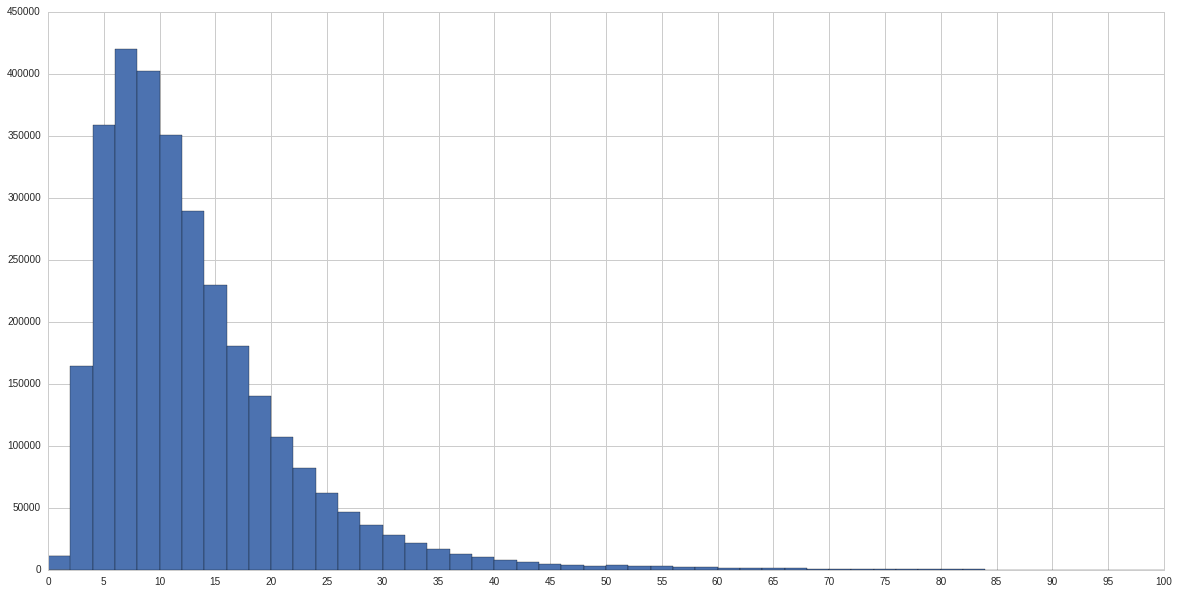

In [74]:
plt.hist(time_regression_df.trip_time_in_mins.values, bins=50, range = [0,100])
plt.locator_params(axis = 'x', nbins = 20)

As we see, most of the trips take between 5 and 25 minutes.

In [76]:
time_regression_df.trip_time_in_mins.quantile([0.1, 0.9])

0.1     4.0
0.9    23.0
Name: trip_time_in_mins, dtype: float64

# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [77]:
from sklearn import cross_validation as cv
y = time_regression_df["trip_time_in_mins"]
X = time_regression_df.ix[:,0:7]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y,test_size=0.1,random_state=0) 

In [78]:
X_test.head()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
1516649,9.0,3.0,6.0,40.770320,-73.959723,40.779322,-73.981232
2960945,11.0,5.0,20.0,40.721652,-74.005242,40.741785,-73.994178
614960,7.0,1.0,10.0,40.751876,-73.979775,40.761881,-73.968245
2178502,10.0,4.0,11.0,40.782880,-73.957486,40.733547,-73.995714
2399519,10.0,4.0,19.0,40.779151,-73.962253,40.765826,-73.976474


In [79]:
y_test.head()

1516649     9.0
2960945     6.0
614960     10.0
2178502    35.0
2399519     7.0
Name: trip_time_in_mins, dtype: float64

In [80]:
Xy_test = pd.concat([X_test, y_test], axis=1)

In [81]:
Xy_test.head()

,pickup_datetime_day,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
1516649,9.0,3.0,6.0,40.770320,-73.959723,40.779322,-73.981232,9.0
2960945,11.0,5.0,20.0,40.721652,-74.005242,40.741785,-73.994178,6.0
614960,7.0,1.0,10.0,40.751876,-73.979775,40.761881,-73.968245,10.0
2178502,10.0,4.0,11.0,40.782880,-73.957486,40.733547,-73.995714,35.0
2399519,10.0,4.0,19.0,40.779151,-73.962253,40.765826,-73.976474,7.0


In [82]:
Xy_test.to_csv('taxi_tree_test_Xy_20130506-12.csv')
X_test.to_csv('taxi_tree_test_X_20130506-12.csv')
y_test.to_csv('taxi_tree_test_y_20130506-12.csv')

In [ ]:
# Xy_test_sample = Xy_test.sample(10000, random_state=99)

In [ ]:
# Xy_test_sample.to_csv('taxi_tree_test_Xy_sample.csv')

In [ ]:
# Xy_test_sample.head()

In [83]:
print(X_train.shape)
print(X_train.size)
print(X_test.shape)
print(X.shape)
print(X_train.shape[0]+X_test.shape[0])

(2719624, 7)
19037368
(302181, 7)
(3021805, 7)
3021805


In [170]:
import time
t = time.time()

In [171]:
print(__doc__)

# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

#features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','pickup_datetime']
#print("* features:", features, sep="\n")


regtree = DecisionTreeRegressor(min_samples_split=3, random_state=99, max_depth=30)# formerly 10. 10 is reasonable
                                                                                     # random states: 99
regtree.fit(X_train, y_train)




Automatically created module for IPython interactive environment


DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=99,
           splitter='best')

In [172]:
elapsed = time.time() - t
print(elapsed)

34.50780963897705


In [175]:
regtree.score(X_test, y_test)

0.63519444982187623

In [174]:
from sklearn import tree
tree.export_graphviz(regtree, out_file='figures/tree_d30.dot', feature_names=time_regression_df.ix[:,0:7].columns, class_names=time_regression_df.columns[7])    

KeyboardInterrupt: 

In [149]:
print(regtree.tree_.feature)
print(regtree.tree_.children_left)
print(regtree.tree_.children_right)

[ 4  6  5 ..., -2 -2 -2]
[ 1  2  3 ..., -1 -1 -1]
[15818 12497  6154 ...,    -1    -1    -1]


Prepare a dictionary to look uop the features that are splitted in the nodes

In [150]:
feature_dict = {}
for i in range(0,7):
    feature_dict[i] = time_regression_df.ix[:,i].name
print(feature_dict)

{0: 'pickup_datetime_day', 1: 'pickup_datetime_dayofweek', 2: 'pickup_datetime_hour', 3: 'pickup_latitude', 4: 'pickup_longitude', 5: 'dropoff_latitude', 6: 'dropoff_longitude'}


In [97]:
feature_splits = list(regtree.tree_.feature)
for i in range(0,len(regtree.tree_.feature)):
    if feature_splits[i] >= 0:
        feature_splits[i] = feature_dict[feature_splits[i]]

In [98]:
print(feature_splits)
print(regtree.tree_.threshold)

['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude', 'dropoff_latitude', 'pickup_latitude', 'dropoff_latitude', -2, -2, 'dropoff_latitude', -2, -2, 'pickup_longitude', 'dropoff_longitude', -2, -2, 'pickup_latitude', -2, -2, 'dropoff_longitude', 'pickup_longitude', 'pickup_datetime_hour', -2, -2, 'pickup_datetime_day', -2, -2, 'dropoff_latitude', 'pickup_latitude', -2, -2, 'pickup_latitude', -2, -2, 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_latitude', -2, -2, 'dropoff_longitude', -2, -2, 'dropoff_longitude', 'pickup_datetime_hour', -2, -2, 'pickup_datetime_hour', -2, -2, 'pickup_latitude', 'dropoff_longitude', 'pickup_latitude', -2, -2, 'pickup_longitude', -2, -2, 'dropoff_latitude', 'dropoff_latitude', -2, -2, 'dropoff_longitude', -2, -2, 'dropoff_latitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_datetime_hour', 'dropoff_latitude', -2, -2, 'dropoff_latitude', -2,

In [99]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print( "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print( "} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print( "}")
                else:
                        print( "return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

In [100]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code_matrix(tree, feature_names):
        decision_list = []
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        #frame =  pd.DataFrame(np.nan, columns=['leaf_no', range(1,tree.tree_.max_depth), 'value'])

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        decision_list.append({str(features[node]):threshold[node]})
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        decision_list.append({'back': -1})
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        decision_list.append({'back': -1})
                else:
                        decision_list.append({'leaf_val':value[node][0][0]})

        recurse(left, right, threshold, features, 0) # root node
        return decision_list

In [101]:
a = get_code_matrix(regtree, feature_names=time_regression_df.ix[:,0:7].columns)

In [102]:
a[0:20]

[{'pickup_longitude': -73.886093139648438},
 {'dropoff_longitude': -73.876411437988281},
 {'dropoff_latitude': 40.711517333984375},
 {'pickup_latitude': 40.735557556152344},
 {'pickup_latitude': 40.721664428710938},
 {'dropoff_longitude': -73.984504699707031},
 {'pickup_longitude': -73.966636657714844},
 {'dropoff_latitude': 40.701427459716797},
 {'pickup_latitude': 40.703460693359375},
 {'dropoff_latitude': 40.652553558349609},
 {'leaf_val': 13.16988416988417},
 {'back': -1},
 {'leaf_val': 8.0531899219095333},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.679161071777344},
 {'leaf_val': 19.431952662721894},
 {'back': -1},
 {'leaf_val': 13.591245376078914},
 {'back': -1}]

In [103]:
len(a)

3213

In [104]:
a[0:20]

[{'pickup_longitude': -73.886093139648438},
 {'dropoff_longitude': -73.876411437988281},
 {'dropoff_latitude': 40.711517333984375},
 {'pickup_latitude': 40.735557556152344},
 {'pickup_latitude': 40.721664428710938},
 {'dropoff_longitude': -73.984504699707031},
 {'pickup_longitude': -73.966636657714844},
 {'dropoff_latitude': 40.701427459716797},
 {'pickup_latitude': 40.703460693359375},
 {'dropoff_latitude': 40.652553558349609},
 {'leaf_val': 13.16988416988417},
 {'back': -1},
 {'leaf_val': 8.0531899219095333},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.679161071777344},
 {'leaf_val': 19.431952662721894},
 {'back': -1},
 {'leaf_val': 13.591245376078914},
 {'back': -1}]

In [105]:
decisions = np.ndarray(shape=(2**regtree.tree_.max_depth, 2*regtree.tree_.max_depth+2), dtype = '<U30')

In [106]:
m = 0
n = 0
for i in range(0,len(a)):
    if (list(a[i].values()) != [-1]):
        #print(n)
        #print(i)
        #print('if')
        #print(list(a[i].keys()) == ['leaf_val'])
        #print(decisions[m,n])
        decisions[m,2*n] = list(a[i].keys())[0]
        decisions[m,2*n+1] = list(a[i].values())[0]
        n = n+1
        #print(n)
    if (list(a[i].keys()) == ['leaf_val']):
        #print('elif')
        m = m+1
        #print(n)
    elif(list(a[i].values()) == [-1]):
        #print('else')
        n = n-1
    #print(n,m)

In [107]:
decisions

array([['pickup_longitude', '-73.8860931396', 'dropoff_longitude', ...,
        '40.6525535583', 'leaf_val', '13.1698841699'],
       ['', '', '', ..., '', 'leaf_val', '8.05318992191'],
       ['', '', '', ..., '40.6791610718', 'leaf_val', '19.4319526627'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [108]:
np.savetxt('decisions.txt', decisions, fmt='%s', delimiter=',')

# decisions.nonzero(): Try somehow to replace the 'None'-values with 'same' or something like that

In [109]:
decisions

array([['pickup_longitude', '-73.8860931396', 'dropoff_longitude', ...,
        '40.6525535583', 'leaf_val', '13.1698841699'],
       ['', '', '', ..., '', 'leaf_val', '8.05318992191'],
       ['', '', '', ..., '40.6791610718', 'leaf_val', '19.4319526627'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [176]:
t = time.time()

In [177]:
from sklearn.ensemble import RandomForestRegressor

rd_regtree = RandomForestRegressor(n_estimators=20,n_jobs=6,min_samples_split=3, random_state=99, max_depth=30) 
#total sum of diff: 1132
#rd_regtree = RandomForestRegressor(n_estimators=40,n_jobs=-1,min_samples_split=3, random_state=99, max_depth=11)
#total sum of diff: 1129
rd_regtree.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=6, oob_score=False, random_state=99,
           verbose=0, warm_start=False)

In [178]:
elapsed_rd_regtree = time.time() - t
print(elapsed_rd_regtree)

133.57636427879333


In [179]:
print(rd_regtree.score(X_test, y_test))

0.786676093283


Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-16.          -8.          -5.          -3.66666667  -2.           0.16455696
   2.11111111   4.9375       7.42857143  15.5       ]
Absolute time deviation (in 1k):  1014.8013595


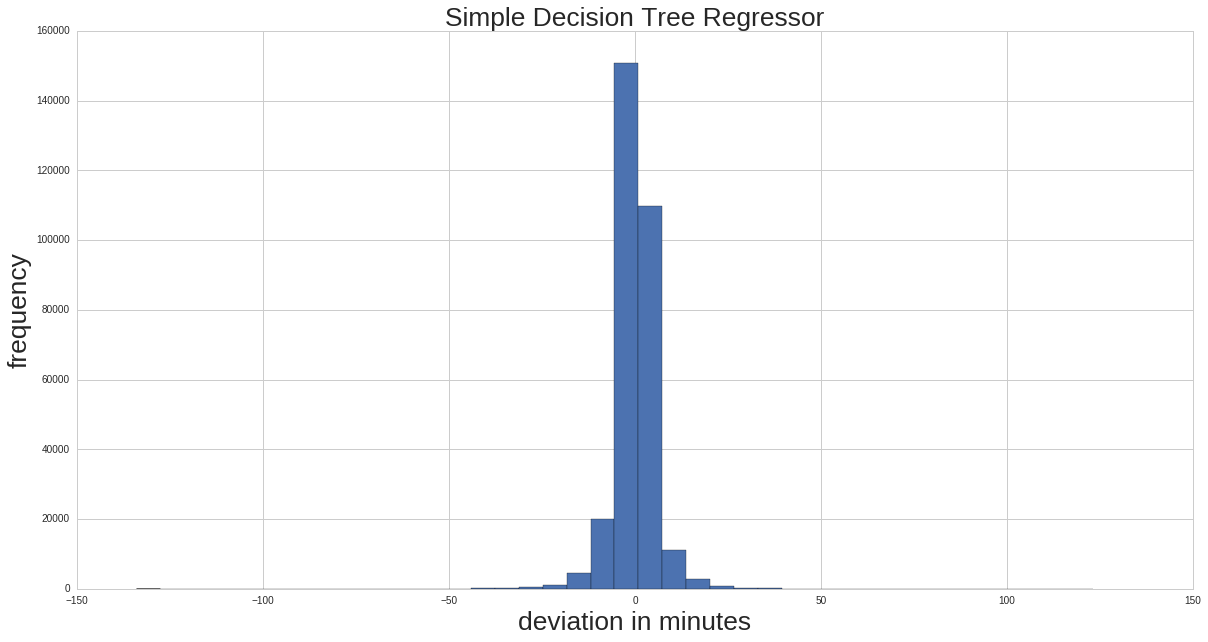

In [180]:
y_pred = regtree.predict(X_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Simple Decision Tree Regressor')
plt.xlabel('deviation in minutes')
plt.ylabel('frequency')

In [181]:
from sklearn.externals import joblib
joblib.dump(regtree, 'treelib/regtree_depth_30_PY27.pkl', protocol=2) 

['treelib/regtree_depth_30_PY27.pkl',
 'treelib/regtree_depth_30_PY27.pkl_01.npy',
 'treelib/regtree_depth_30_PY27.pkl_02.npy',
 'treelib/regtree_depth_30_PY27.pkl_03.npy']

In [182]:
regtree.tree_.max_depth

30

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-13.  -6.  -4.  -2.  -1.   1.   3.   4.   6.  10.]
Absolute time deviation (in 1k):  828.733


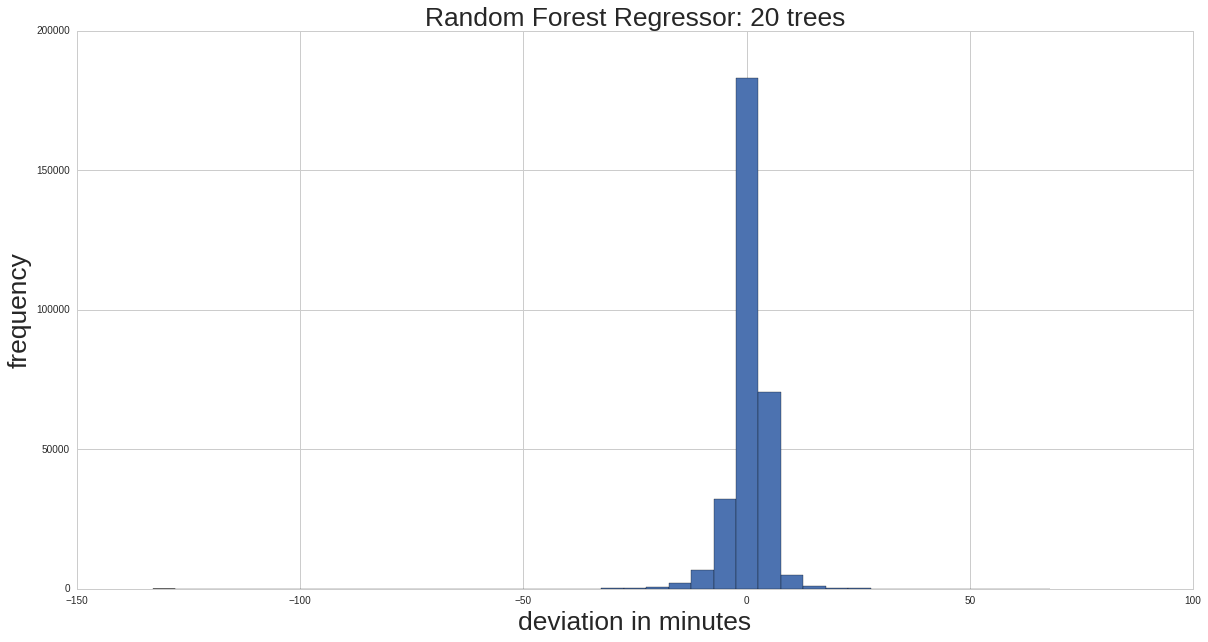

In [183]:
percentiles = [1,5,10,15,25,50,75,90,95,99]
y_pred = rd_regtree.predict(X_test)
np.linalg.norm(y_pred-y_test)
diff = (np.ceil(y_pred)-y_test)
#plt.figure(figsize=(12,10))
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', percentiles , '\n', np.percentile(diff.values, percentiles))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Random Forest Regressor: 20 trees')
plt.xlabel('deviation in minutes')
plt.ylabel('frequency')

In [184]:
from sklearn.externals import joblib
joblib.dump(rd_regtree, 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl', protocol=2)

['randforlib/regtree_20x_depth_30_PY27.pkl.pkl',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_01.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_02.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_03.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_04.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_05.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_06.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_07.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_08.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_09.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_10.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_11.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_12.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_13.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_14.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_15.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_16.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_17.npy',

In [186]:
! cd randforlib && zip regtree_20x_depth_30.zip regtree_20x_depth_30_PY27.pkl.pkl*

updating: regtree_20x_depth_30_PY27.pkl.pkl (deflated 72%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_01.npy (deflated 19%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_02.npy (deflated 81%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_03.npy (deflated 70%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_04.npy (deflated 19%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_05.npy (deflated 81%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_06.npy (deflated 70%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_07.npy (deflated 19%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_08.npy (deflated 81%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_09.npy (deflated 70%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_10.npy (deflated 19%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_11.npy (deflated 81%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_12.npy (deflated 70%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_13.npy (deflated 19%)
updating: regtree_20x_depth_30_PY27.pkl.pkl_14.npy (deflated 81%)
updating: regtree

## Read as follows: Split # x results in the children_left[x] and children_right[x], etc. Means: go to the left, and then step by step to the right...

In [130]:
print('cleft: ' + str(regtree.tree_.children_left) + '\n\n', #array of left children
      'cright: ' + str(regtree.tree_.children_right) + '\n\n', #array of right children
    regtree.tree_.feature, '\n\n',#array of nodes splitting feature
    regtree.tree_.threshold, '\n\n', #array of nodes splitting points
    #regtree.tree_.value
     ) #array of nodes values

cleft: [   1    2    3 ..., 1605   -1   -1]

 cright: [ 894  507  254 ..., 1606   -1   -1]

 [ 4  6  5 ...,  5 -2 -2] 

 [-73.88609314 -73.87641144  40.71151733 ...,  40.83932495  -2.          -2.        ] 




numpy.ndarray(regtree.tree_.children_left #array of left children
regtree.tree_.children_right #array of right children
regtree.tree_.feature #array of nodes splitting feature
regtree.tree_.threshold #array of nodes splitting points
regtree.tree_.value #array of nodes values

## Finding leaves:

In [131]:
leaves = regtree.tree_.children_left*regtree.tree_.children_right
for idx, a in enumerate(leaves):
    if a==1:
        x=1# do nothing
    else:
        leaves[idx] = 0
print(leaves)

[0 0 0 ..., 0 1 1]


## Now we've found the leaves

In [132]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

# Seems that the first 3 features are quite irrelevant right now...

In [133]:
splits = regtree.tree_.threshold

[  7.5  10.5   5.5   5.5   7.5   9.5  20.5   9.5  17.5   6.5   7.5  17.5
  10.5   6.5  17.5   6.5   7.5   6.5  17.5   6.5   5.5   7.5   6.5   6.5
  17.5  10.5   7.5   7.5   7.5   6.5  19.5   6.5   6.5  17.5   7.5   6.5
   6.5   6.5  18.5  18.5   6.5  10.5   5.5   5.5   7.5  19.5  18.5   4.5
  11.5   6.5  17.5   6.5   9.5   7.5   8.5   9.5   0.5  19.   14.5   4.5
  17.5   9.5   6.5  17.5   2.5  20.5   6.5  18.5   3.5  14.5  20.5   4.5
  14.   20.    9.5   2.5  17.5  15.5  11.   13.5  12.5   8.5   2.    1.5
  10.5  16.5   6.5  14.5   4.5  14.5  11.5  17.5   4.5   7.5  17.5  10.5
   7.5  19.   17.   13.5   8.5  18.5  19.5  12.5   8.5  15.5  14.5  22.5
   7.5   3.5  13.5   4.5   1.5   9.5   6.5   3.5   6.5   3.5   8.5   6.5
   9.5   8.5   6.5   7.5   0.5   5.5   8.5  10.5  17.5   3.5  16.5  14.5
  11.5   3.5   2.5  11.5  18.5  10.5   4.5   6.5  19.5  22.5  19.5  15.5
  21.   13.5   7.5  13.5  13.5   6.5  14.5  17.5  12.5   5.   10.5   7.5
  10.5   3.5   4.5  18.5   7.5   4.5   5.5   3.   2

(array([ 10.,  21.,  36.,  27.,  22.,  18.,  12.,  20.,  19.,  10.]),
 array([  0.5,   2.7,   4.9,   7.1,   9.3,  11.5,  13.7,  15.9,  18.1,
         20.3,  22.5]),
 <a list of 10 Patch objects>)

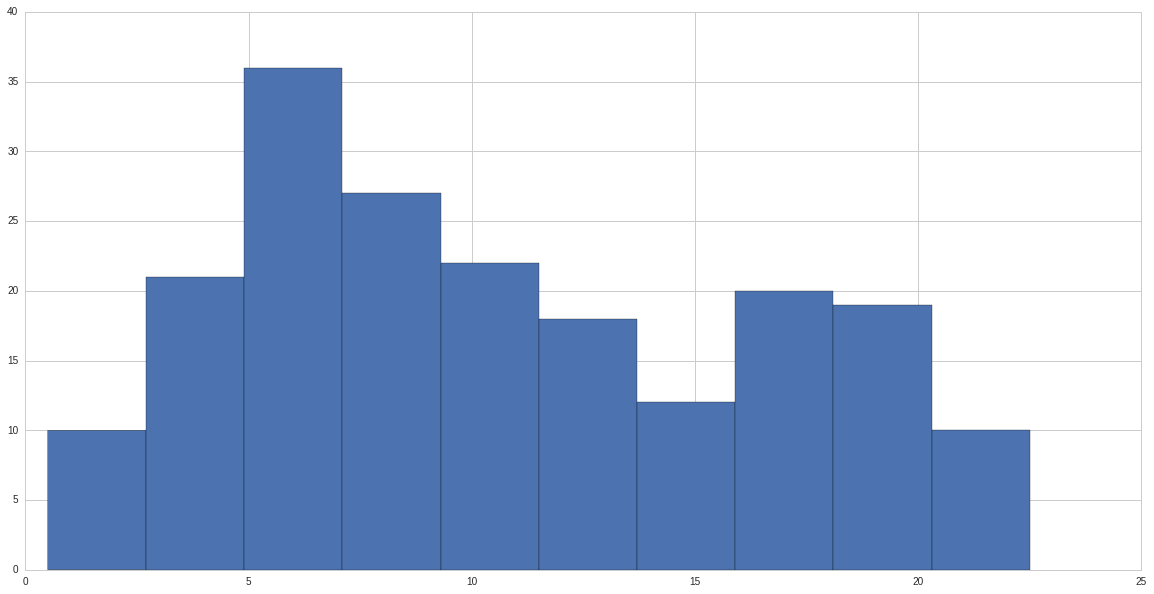

In [134]:
time_splits = splits[(splits>=0) & (splits<=24)]
print(time_splits)
plt.hist(time_splits)

# Where are splits in the hour?

# Filter the splits in longitudinal and latitudinal data

In [135]:
long_splits = splits[(splits>=-75) & (splits<=-70)]
lat_splits = splits[(splits>=40) & (splits<=41)]

# <font color = 'red'> The MSE of each node is stored in the 'impurity'-property. </font color>

In [136]:
#np.multiply(regtree.tree_.value, 1/ regtree.tree_.n_node_samples).size
avg_time_dev = regtree.tree_.impurity.T  * leaves
#avg_time_dev = (np.array(regtree.tree_.value)/np.array(regtree.tree_.n_node_samples)) *np.array(leaves)
avg_time_dev = avg_time_dev[avg_time_dev!=0]

In [137]:
avg_time_dev

array([  2.98089772e+01,   2.39769852e+01,   3.13388607e+01,
         2.25332896e+01,   2.22804048e+01,   2.99869810e+01,
         3.83369750e+01,   2.07098672e+01,   2.49863999e+01,
         3.77843762e+01,   3.68750000e+00,   1.60710059e+01,
         1.53722751e+01,   2.27125283e+01,   2.16740895e+01,
         1.81328277e+01,   2.32361592e+01,   2.88596873e+01,
         2.24318451e+01,   3.06682575e+01,   4.13069070e+01,
         4.40175256e+01,   2.16962707e+01,   5.83257618e+01,
         2.71539050e+01,   3.55195072e+01,   3.75072676e+01,
         3.25642177e+01,   2.99232070e+01,   2.76129658e+01,
         1.57879788e+01,   4.18594231e+01,   4.21534048e+01,
         2.20587055e+01,   3.48223561e+01,   3.56734211e+01,
         3.61657643e+01,   2.69355102e+01,   9.62162162e+01,
         6.51634349e+01,   2.21484900e+01,   2.22534582e+01,
         4.93639922e+01,   2.61742245e+01,   3.18070081e+01,
         5.54020911e+01,   1.63907765e+01,   1.34724911e+01,
         1.03401265e+01,

In [138]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

(array([  87.,   63.,  108.,   87.,   60.,   50.,   26.,   35.,   33.,
          20.,   16.,   13.,   13.,   13.,    4.,    3.,    7.,    2.,
           7.,    5.,    4.,    2.,    3.,    1.,    3.,    2.,    3.,
           1.,    1.,    2.,    3.,    1.,    2.,    2.,    0.,    1.,
           1.,    1.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,
           0.,    0.,    1.,    1.,    0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.]),
 <a list of 50 Patch objects>)

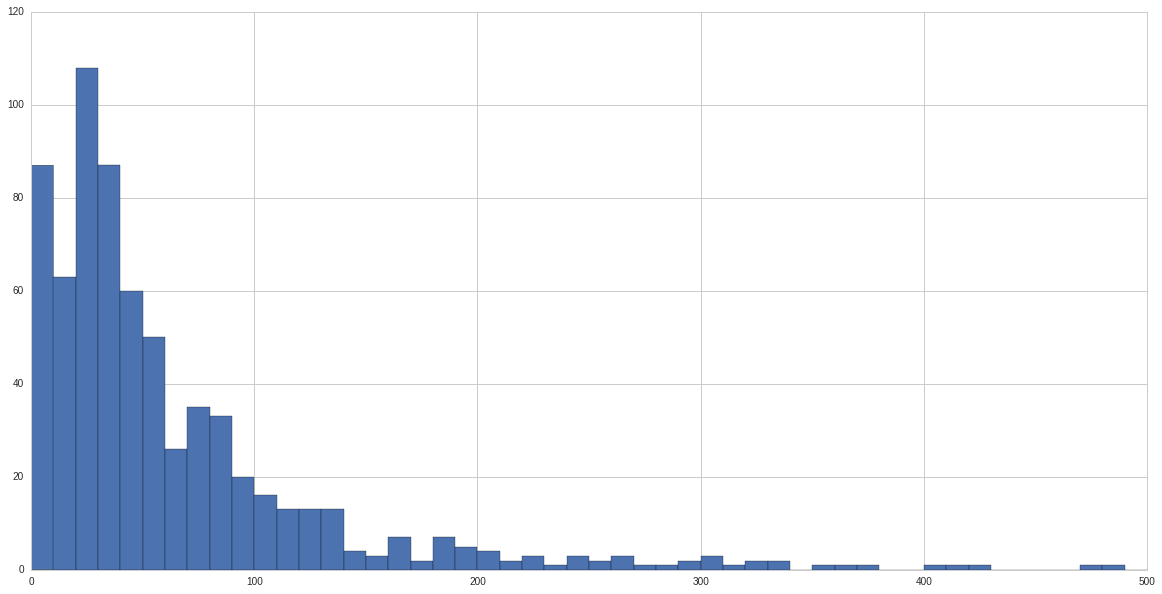

In [139]:
h = avg_time_dev
plt.hist(h.tolist(), bins=50, range=[0, 500])

In [140]:
np.percentile(avg_time_dev, q=[5, 50, 75, 90, 95, 97.5, 99])

array([   2.25      ,   40.40453686,   80.65816075,  144.65208316,
        233.20489438,  328.16237289,  488.59704894])

In [142]:
time_regression_df.columns[0:7]

Index(['pickup_datetime_day', 'pickup_datetime_dayofweek',
       'pickup_datetime_hour', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

# <font color = 'blue'> Now we want to visualize the decision tree. To do so, plot the splits in geodata on the map of NYC (together with the heat map) </font color>

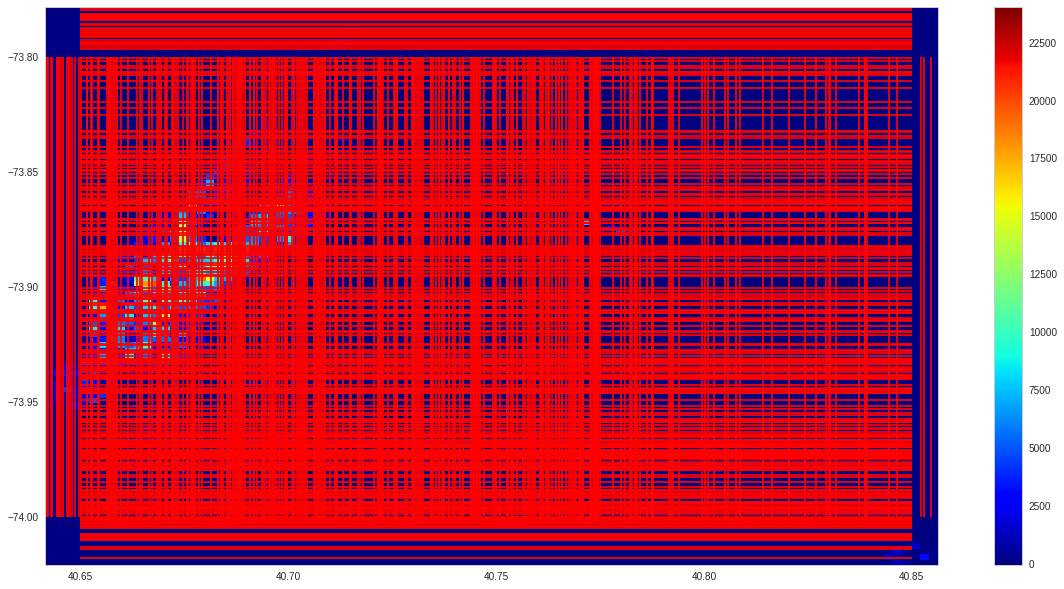

In [143]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

## Plot the horizontal / vertival lines here via eventplot
plt.hold(True)
plt.eventplot(lat_splits, orientation='horizontal', lineoffsets=-73.9,
          linelengths=0.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.eventplot(long_splits, orientation='vertical', lineoffsets=40.75,
          linelengths=.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.axis([xedges.min(),xedges.max(),yedges.min(),yedges.max()]) # zoom in
plt.hold(False)